# Testing Cross Validation Strategies
Many data science projects aim for generalizable models---models that perform well on new data---such as scoring new credit card applicants or predicting who will win a football game. A common approach to modeling is to split your data, using different splits for different tasks. If you have a lot of data, you might split it into three subsets:

* **Train set** for fitting candidate models
* **Validation set** for selecting a model ('which of the fitted candidate models is best?')
* **Test set** for assessing the selected model ('how accurate is the best model?')

A more common approach is to use cross validation. Cross validation eliminates the need for a separate validation set by using the train set for training and validation:

* split the train set into k folds
* fit the model(s) on all but the kth fold and test on the kth fold
* fit the model(s) on all but the (k-1)th fold and test on the (k-1)th fold
* ...
* fit the model(s) on all but the 1st fold and test on the 1st fold

In both cases, we retrain the selected model on all the training and validation sets before testing.

How you choose to split the data for training, validating, and testing is critical. If your train set contains information about the validation or test sets that would not be available in the real world, your model selection and assessment may be wrong. This is a type of *leakage*, and it can lead to wrong model choice and overly optimistic error estimates. 

We typically learn to do "standard cross validation," where the splits are made randomly. That works well for independent and identically distributed data, but many (most?) real-world problems have dynamic data-generating processes that make standard CV less than ideal. You'll typically do better splitting the data in a way that mimics how the model will be used. For example, if you're trying to build a good forecasting model, you should probably split the data by time. That way you'll choose the model that would have forecasted best, rather than the model that best predicted some combination of the future and past.   

This notebook presents a couple simple prediction problems with publicly available data covering a long time range. It compares several model selection and assessment strategies:

* *None*: No validation set. Choose the model with the lowest training error for testing.
* *Standard*: Choose the model with lowest error in standard CV.
* *Standard with holdout*: Set aside the last x time as a holdout set. Use standard CV on the rest of the data to choose a model. (This is common in many of the best social science prediction papers.)
* *Temporal with holdout*: Set aside the last x time as a holdout set. Use temporal CV on the rest of the data to choose a model.  
* *Temporal*: Choose the model with lowest error in temporal CV.

We will compare the performance of each on the following:

* *Model selection*: Would the strategy have chosen the best model?
* *Model assessment*: Would the strategy provided an accurate estimate of model error?

The first example uses regression to predict annual US GDP, and the second uses classification to predict recidivism.

In [1]:
import csv
from itertools import product
from multiprocessing import Pool

import numpy as np
import pandas as pd
from plotnine import *
from sklearn import linear_model, ensemble, metrics

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Regression Example: Predicting US Gross Domestic Product
Let's say it's December 31, 2017, and we want to predict next year's nominal US Gross Domestic Product (GDP). So we'll try to do two things:

1. Choose the model that is most likely to give us an accurate estimate for 2018.
2. Estimate how accurate we should expect that model to be in 2018, so we have a sense for how much we can trust the results.

We don't know what will happen in 2018, but we do know what happened in 2017, 2016, 2015, and so on. We can simulate what would have happened if we tried fitting, validating, and testing models in the past, the same way we want to do now.  
<!---If it's reasonable to assume [stationarity](https://en.wikipedia.org/wiki/Stationary_process) and a thin-tailed distribution (which GDP may not be, but this is an example), this historical approach can work quite well.--->

Here's how we would have done if we were predicting GDP for 2017:

1. Choose the model that performed best through 2016.
2. Fit the best model on all data available through 2016, predict for 2017, and compare our prediction to the actual GDP.

We can do the same thing for the year before:

1. Choose the model that performed best through 2015.
2. Fit the best model on all data available through 2016, predict for 2016, and compare our prediction to the actual GDP.

And repeat again and again, each time a year earlier. We'll try all our model-selection strategies in each loop. 

We collected data from six sources:

* [GDP](https://bea.gov/iTable/iTable.cfm?ReqID=19&step=4&isuri=1&1921=flatfiles) from the Bureau of Economic Analysis (code T10105-A)
* [Historical oil prices](https://www.eia.gov/dnav/pet/hist/LeafHandler.ashx?n=pet&s=rwtc&f=a) from US Energy Information Administration (Cushing, OK WTI Spot Price, starts in 1986)
* Presidential Election Year
* Republican Administration
* [US population](http://www.multpl.com/united-states-population/table)
* [S&P 500 Price-Earnings Ratio](http://www.multpl.com/table)
* A column from a random number generator

Let's start by plotting GDP over time.

In [2]:
GDP_df = pd.read_csv('GDP.csv')

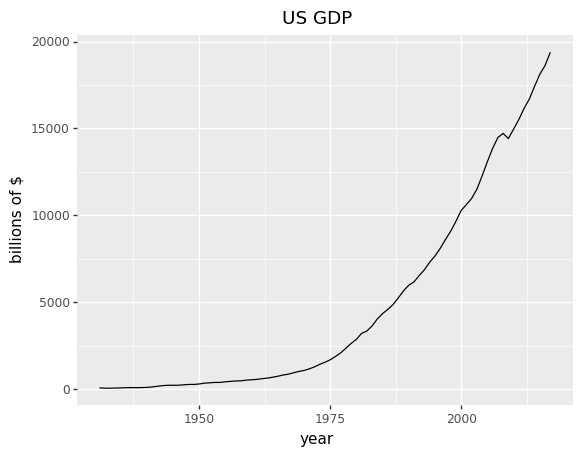

<ggplot: (-9223372036561916384)>

In [3]:
(ggplot(GDP_df, aes(x='year', y='GDP')) +
    geom_line() +
    ggtitle('US GDP') +
    xlab('year') +
    ylab('billions of $')
)

<!--Look at the dip after 2000. If you randomly assign rows to the train, validate, and test sets, your model might fit post-Great Recession data and validate/test on Great Recession data. Then the model effectively knows GDP drops before it happens, resulting in error rates that are too small for the validation and test sets.  

<!--**To avoid problems like this, you should design your train/validation/test splits to mimic how you will use your model.**--> 
GDP is our target variable. I created several features. If we want to predict what GDP will be next year, we can't use next year's features. The features need to precede the target, i.e. the features need to be from this year or the past:

* The year
* Previous year's GDP
* GDP from two years before
* Previous year's oil price. The data only go back to 1986. I zero imputed the rest.
* Presidential Election Year (takes a 1 if an election year and a 0 otherwise)
* Republican Administration (takes a 1 if the president is a Republican and a 0 otherwise)
* Previous year's population
* Previous year's S&P 500 Price-Earnings Ratio
* A random integer between 0 and 1000. It should only predict the outcome by chance.

Here's what the data look like:

In [259]:
GDP_df.head(n=15)

,year,GDP,GDP lag 1,GDP lag 2,Election Year,Republican Administration,oil prices lag 1,Population lag 1,S&P 500 PE Ratio lag 1,Random
0,1931,77.406,92.167,104.560,0,1,0.0,123.08,13.92,481
1,1932,59.532,77.406,92.167,1,1,0.0,124.04,17.00,65
2,1933,57.165,59.532,77.406,0,0,0.0,124.84,14.07,737
3,1934,66.812,57.165,59.532,0,0,0.0,125.58,17.29,682
4,1935,74.259,66.812,57.165,0,0,0.0,126.37,23.95,51
5,1936,84.854,74.259,66.812,1,0,0.0,127.25,16.25,522
6,1937,93.029,84.854,74.259,0,0,0.0,128.05,17.87,441
7,1938,87.387,93.029,84.854,0,0,0.0,128.82,16.75,694
8,1939,93.473,87.387,93.029,0,0,0.0,129.82,10.47,875
9,1940,102.946,93.473,87.387,1,0,0.0,130.88,18.94,778


How many observations do the models have for fitting?

In [5]:
GDP_df.shape[0]

87

Let's define the features and target: 

In [6]:
X_cols = ['year', 'GDP lag 1', 'GDP lag 2', 'Election Year', 'Republican Administration',
          'oil prices lag 1', 'Population lag 1', 'S&P 500 PE Ratio lag 1', 'Random']
y_cols = 'GDP'

In practice, we can try [hundreds](https://github.com/rayidghani/magicloops/blob/master/mlfunctions.py) or even thousands of model types. To keep things simple, we'll try four here:

* Ordinary least squares (with an intercept)
* Ridge regression (OLS with an L2 penalty on the coefficients. For this exercise, I decided to try a penalty of 100.)
* Elasticnet (OLS with L1 and L2 penalty terms on the coefficients. For this exercise, I decided to try a penalty of 100 and equal weights on the L1 and L2 penalty terms.)
* Random forest (10,000 trees, max depth of 5, max features of 5)

In [7]:
clfs = {
    'ols': linear_model.LinearRegression(),
    'ridge': linear_model.Ridge(alpha=100),
    'elastic': linear_model.ElasticNet(alpha=100)#,
    #'random_forest': ensemble.RandomForestRegressor(n_estimators=10000, max_depth=5, max_features=5)
}

We need to define the range of years for the test sets. Although the data begin in the early 1930s, our test sets begin in the 1940s. One of our models uses OLS, which requires at least as many rows of data as columns to fit the model. We have 9 predictors (see `X_cols`) plus an intercept, so we need at least 10 rows to fit the model. We get enough rows using 1931 through 1940.

We also need an extra row (year) for validation -- we'll use 1941 for that -- so the first possible test year is 1942. (The results will probably be terrible, given how little training data we had and our model selection is based on a single observation.)

In [260]:
test_begin_year = 1942
test_end_year = 2017  # short for rapid testing
test_years = range(test_begin_year, test_end_year+1)

A couple of validation-set rules:

1. Validation set labels should precede the test set labels
2. For temporal cross validation, validation set labels should follow train set labels. 

On #2, Standard cross validation can use 1931 - 1940 GDPs as validation sets, but temporal cross validation cannot, given the requirement of OLS stated above.

In [261]:
temporal_validation_years = range(test_begin_year-1, test_end_year)
standard_validation_years = range(1931, test_end_year)

To visualize the difference between the the two CV techniques, assume it's 1942 and we want to predict GDP for 1943.

#### Example comparison:   
Standard CV can use 1931 - 1942 for validation years.
* Standard CV produces the following validation and train sets
    * Validation: 1931, Training: 1932 - 1942
    * Validation: 1932, Training: 1931 & 1933 - 1942
    * Validation: 1933, Training: 1931 - 1932 & 1934 - 1942
    * Validation: 1934, Training: 1931 - 1933 & 1935 - 1942
    * Validation: 1935, Training: 1931 - 1934 & 1936 - 1942
    * Validation: 1936, Training: 1931 - 1935 & 1937 - 1942
    * Validation: 1937, Training: 1931 - 1936 & 1938 - 1942
    * Validation: 1938, Training: 1931 - 1937 & 1939 - 1942
    * Validation: 1939, Training: 1931 - 1938 & 1940 - 1942
    * Validation: 1940, Training: 1931 - 1939 & 1941 - 1942
    * Validation: 1941, Training: 1931 - 1940 & 1942
    * Validation: 1942, Training: 1931 - 1941
         
         
Temporal CV can use 1941 - 1942 for validation years.
* Temporal CV produces the following validation and train sets
    * Validation: 1941, Training: 1931 - 1940
    * Validation: 1942, Training: 1931 - 1941
    
Note that the validation errors on each fold will converge toward the later years of the training set, as the training and validation data become more similar. Our leave-one-out CV strategy and temporal CV will give exactly the same results for the 1942 validation fold because the training (1931-1941) and validation (1942) data are the same. 

You'll almost always want to choose a validation and testing strategy that most closely mimics how your model will be used. If you don't, you'll choose a model that performs well for a different problem than the one you're trying to solve. In this example, where you want to predict GDP for 1951, you should choose temporal cross validation because you don't have data from after 1950 (in our hypothetical). Training the model on future data and testing on the past is cheating because the future contains information about the past. As a result, standard cross validation will tend to give errors that are too small.  

## Standard Cross Validation

In [262]:
def standard_etl_fit_evaluate(df, test_year, validation_year, model):
    
    if validation_year < test_year:
        
        try:
            cv_start = 1931
            cv_end = test_year - 1
            
            # prep validation data
            df_validation = df[df.year == validation_year]
            X_validation = df_validation[X_cols]
            y_validation = df_validation[y_cols]

            # prep training data
            df_standard_train = df[(df.year != validation_year) & (df.year < test_year)]
            X_standard_train = df_standard_train[X_cols]
            y_standard_train = np.ravel(df_standard_train[y_cols])

            # fit the models
            clf = clfs[model]
            clf.fit(X_standard_train, y_standard_train)
            train_error = metrics.mean_squared_error(y_standard_train, clf.predict(X_standard_train))
            validation_error = metrics.mean_squared_error(y_validation, clf.predict(X_validation))

            # return the results
            return(cv_start, cv_end, validation_year, model, train_error, validation_error)
        
        except:
            pass

In [263]:
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

The cross validation requires training the models many times over. This can either be done sequentially or with parallelization. Both are demonstrated below and produce the same results. You can change with method is used by changing the boolean `parallel`.

In [264]:
parallel = True

if parallel:
    pool = Pool()
    standard_cv_results = pool.starmap(standard_etl_fit_evaluate, product([GDP_df], test_years, standard_validation_years, clfs))
    standard_cv_results_df = pd.DataFrame([x for x in standard_cv_results if x is not None],
                                  columns=['cv_start', 'cv_end', 'validation_year', 
                                           'model', 'train_error', 'validation_error'])
    pool.close()
    
else:
    standard_cv_results = []
    for test_yr in test_years:
        for validation_yr in [year for year in standard_validation_years if year < test_yr]:
            for model in clfs:
                results = standard_etl_fit_evaluate(GDP_df, test_yr, validation_yr, model)
                standard_cv_results.append(results)
                
    standard_cv_results_df = pd.DataFrame(standard_cv_results,
                                  columns=['cv_start', 'cv_end', 'validation_year', 
                                           'model', 'train_error', 'validation_error'])
    

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/pyth

In [265]:
standard_cv_results_df.sort_values('cv_end')
standard_cv_results_df['cv_strategy'] = 'standard'

In [266]:
standard_cv_results_df.head(n=15)

,cv_start,cv_end,validation_year,model,train_error,validation_error,cv_strategy
0,1931,1941,1931,ols,2.097574,408.655534,standard
1,1931,1941,1931,ridge,42.502346,3.360430,standard
2,1931,1941,1931,elastic,151.073179,302.451349,standard
3,1931,1941,1932,ols,2.097574,408.655534,standard
4,1931,1941,1932,ridge,29.332626,445.256076,standard
5,1931,1941,1932,elastic,120.570632,1098.821617,standard
6,1931,1941,1933,ols,5.368010,661.342432,standard
7,1931,1941,1933,ridge,40.631712,3.074484,standard
8,1931,1941,1933,elastic,192.487312,237.894936,standard
9,1931,1941,1934,ols,0.003229,939.443373,standard


With these results from the cross validation, we can then simulate our process of choosing which model we will use for each of the testing years. To do so, for each fold group (characterized by having the same final cv year) and model type, we average the cv errors from all of the validation years. Then we select the model with the lowest average cv error for the prior years to be our chosen model for that test year. Finally, we compare the performace of the test year's predicted value for GDP with its actual value to get our test error for that year.

In [267]:
# Grouping by the test year and the model type, what is the average cv_error?
grouped_standard_cv_results = standard_cv_results_df.groupby(['cv_end', 'model'])['validation_error'].mean().to_frame().reset_index()
grouped_standard_cv_results.rename(columns = {"validation_error": "mean_validation_error"}, inplace=True)

grouped_standard_cv_results.head(n=15)

,cv_end,model,mean_validation_error
0,1941,elastic,416.452873
1,1941,ols,810.229905
2,1941,ridge,181.366507
3,1942,elastic,485.553967
4,1942,ols,332.453339
5,1942,ridge,155.729830
6,1943,elastic,301.197741
7,1943,ols,169.965608
8,1943,ridge,98.776924
9,1944,elastic,293.769001


In [268]:
# Finding the models with the lowest average cv_error for each year
standard_cv_best_models = grouped_standard_cv_results.loc[grouped_standard_cv_results.groupby(['cv_end'])\
                                                         ['mean_validation_error'].idxmin()]

In [269]:
standard_cv_best_models.head(n=10)

,cv_end,model,mean_validation_error
2,1941,ridge,181.366507
5,1942,ridge,155.729830
8,1943,ridge,98.776924
11,1944,ridge,91.886425
14,1945,ridge,78.845364
16,1946,ols,67.401535
19,1947,ols,95.767009
23,1948,ridge,138.371706
26,1949,ridge,183.607637
29,1950,ridge,182.665467


Now, to estimate the test error of each of our best models, we need to find the error of that model when it is trained on all the years prior to the test year and evaluated on the test year. Eg: the test error for OLS in 1943 is the error produced when OLS is trained on data from 1931 to 1942 and tested on 1943. 

 Recall that this is exactly one of the K folds performed in the original running of the models stored in `standard_cv_results_df`. In particular, it is when `cv_end` = `validation_year` = 1943.  So instead of retraining the model, we can simply retrieve the error calculated before. Except the final test year (1950 in this case), which must be calculated.

In [270]:
test_errors = []
for index, row in standard_cv_best_models.iterrows():
    cv_end_yr = row["cv_end"]
    model = row["model"]
    
    if cv_end_yr + 1 != test_end_year:
        test_error = standard_cv_results_df[(standard_cv_results_df.cv_end == cv_end_yr) \
                                          & (standard_cv_results_df.validation_year == cv_end_yr)
                                          & (standard_cv_results_df.model == model)].iloc[0]["validation_error"]
    else:
        results = standard_etl_fit_evaluate(GDP_df, cv_end_yr + 1 , cv_end_yr, model)
        test_error = results[5]
        
    test_errors.append(test_error)

standard_cv_best_models["test_error"] = test_errors
standard_cv_best_models["type"] = "standard"
standard_cv_best_models.rename(columns={"cv_end":"test_year"}, inplace=True)
standard_cv_best_models["test_year"] = standard_cv_best_models["test_year"] + 1 # To go from cv end to test year

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [271]:
standard_cv_best_models.head(n=15)

,test_year,model,mean_validation_error,test_error,type
2,1942,ridge,181.366507,1212.469405,standard
5,1943,ridge,155.729830,593.902513,standard
8,1944,ridge,98.776924,29.167279,standard
11,1945,ridge,91.886425,85.521292,standard
14,1946,ridge,78.845364,14.163702,standard
16,1947,ols,67.401535,11.453545,standard
19,1948,ols,95.767009,308.069982,standard
23,1949,ridge,138.371706,35.599395,standard
26,1950,ridge,183.607637,639.072714,standard
29,1951,ridge,182.665467,307.436476,standard


## Temporal Cross Validation

Temporal CV approaches the problem slightly differently. It uses the same set of validation years, but only trains on the years before the validation year, not the years after. In this way, it eliminates data leakage that can cause overfitting in models trained with Standard CV.
    
Note that, with temporal CV, each test year starts with the same validation and training sets. Therefore we do not have to retrain all of the models for every test year, so temporal CV is also much more efficient for our project. We can simply train all 4 models on each possible training set (1931 - 1939, 1931 - 1940, 1931 - 1941, ...) and store the results. Then, for a given test year, for each model, we simply average all the validation errors from the years prior. Standard CV is far less efficient because validation requires unique train and validation sets. We cannot reuse results from another run.

In [272]:
def temporal_etl_fit_evaluate(df, year, model):
    
    cv_start = 1931
    cv_end = year
    validation_year = year
    
    # validation set
    df_validation = df[df.year == year]
    X_validation = df_validation[X_cols]
    y_validation = df_validation[y_cols]
    
    # train set - all years prior to validation year
    df_temporal_train = df[df.year < year]
    X_temporal_train = df_temporal_train[X_cols]
    y_temporal_train = np.ravel(df_temporal_train[y_cols])
    
    # fit the models for testing
    clf = clfs[model]
    clf.fit(X_temporal_train, y_temporal_train)
    train_error = metrics.mean_squared_error(y_temporal_train, clf.predict(X_temporal_train))
    test_error = metrics.mean_squared_error(y_validation, clf.predict(X_validation))
    
    return(cv_start, cv_end, validation_year, model, train_error, test_error)

Once again, we can use either a parallel or a sequential fitting of the models for all of the folds of the cross validation. 

In [273]:
parallel = True

if parallel:
    pool = Pool()
    temporal_results = pool.starmap(temporal_etl_fit_evaluate, product([GDP_df], temporal_validation_years, clfs))
    
    pool.close()
    
else:
    temporal_results = []
    for validation_year in temporal_validation_years:
        for model in clfs:
            results = temporal_etl_fit_evaluate(GDP_df, validation_year, model)
            temporal_results.append(results)

    
temporal_results_df = pd.DataFrame(temporal_results,
                                  columns=['cv_start', 'cv_end', 'validation_year', 
                                           'model', 'train_error', 'validation_error'])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/pyth

In [274]:
temporal_results_df.head(n=12)

,cv_start,cv_end,validation_year,model,train_error,validation_error
0,1931,1941,1941,ols,1.492432,3037.728767
1,1931,1941,1941,ridge,18.648039,1212.469405
2,1931,1941,1941,elastic,108.158942,2547.322039
3,1931,1942,1942,ols,5.818796,650.773170
4,1931,1942,1942,ridge,37.498231,593.902513
5,1931,1942,1942,elastic,177.566218,2493.282681
6,1931,1943,1943,ols,8.756661,48.144871
7,1931,1943,1943,ridge,44.470095,29.167279
8,1931,1943,1943,elastic,190.335469,492.357335
9,1931,1944,1944,ols,8.622025,113.319559


Recall that cv_start and cv_end mark are the inclusive bounds for the validation fold. Thus the training set is all the years in that fold except for the validation year. Temporal CV only ever validates on the last year of the set.

As described above, for each validation year we now can average the test errors from the years less than or equal to that year to get our test average cv error. This should match the form of `grouped_standard_cv_results`.

In [275]:
rows_list = []
for validation_yr in temporal_validation_years:
    for model in clfs:
        row_dict = {}
        row_dict["model"] = model
        row_dict["cv_end"] = validation_yr
        row_dict["mean_validation_error"] = temporal_results_df[(temporal_results_df.validation_year <= validation_yr) \
                & (temporal_results_df.model == model)]["validation_error"].mean()
        rows_list.append(row_dict)
        
grouped_temporal_cv_results = pd.DataFrame(rows_list)
grouped_temporal_cv_results.head(n=12)

,cv_end,mean_validation_error,model
0,1941,3037.728767,ols
1,1941,1212.469405,ridge
2,1941,2547.322039,elastic
3,1942,1844.250968,ols
4,1942,903.185959,ridge
5,1942,2520.302360,elastic
6,1943,1245.548936,ols
7,1943,611.846399,ridge
8,1943,1844.320685,elastic
9,1944,962.491592,ols


Just like the standard CV example, we can chose the best model for each test year from these mean validation errors and then retrieve the test errors from our run of all the validation sets stored in `temporal_results_df`. Like Standard CV, our final test year (1950) was never used as a validation set.

In [276]:
# Finding the models with the lowest average cv_error for each year
temporal_cv_best_models = grouped_temporal_cv_results.loc[grouped_temporal_cv_results.groupby(['cv_end'])\
                                                         ['mean_validation_error'].idxmin()]
temporal_cv_best_models.head(n=14)

,cv_end,mean_validation_error,model
1,1941,1212.469405,ridge
4,1942,903.185959,ridge
7,1943,611.846399,ridge
10,1944,480.265122,ridge
13,1945,387.044838,ridge
16,1946,339.068691,ridge
19,1947,432.967345,ridge
22,1948,383.296351,ridge
25,1949,411.715947,ridge
28,1950,401.288000,ridge


In [277]:
test_errors = []
for index, row in temporal_cv_best_models.iterrows():
    cv_end_yr = row["cv_end"]
    model = row["model"]
    
    if cv_end_yr + 1 != test_end_year:
        test_error = temporal_results_df[(temporal_results_df.validation_year == cv_end_yr)
                                       & (temporal_results_df.model == model)].iloc[0]["validation_error"]
    else:
        results = temporal_etl_fit_evaluate(GDP_df, cv_end_yr, model)
        test_error = results[5]
        
    test_errors.append(test_error)

temporal_cv_best_models["test_error"] = test_errors

#Reordering columns and adding type
temporal_cv_best_models["type"] = "temporal"
temporal_cv_best_models.rename(columns={"cv_end":"test_year"}, inplace=True)
temporal_cv_best_models["test_year"] = temporal_cv_best_models["test_year"] + 1 # To go from cv end to test year

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [278]:
temporal_cv_best_models.head(n=15)

,test_year,mean_validation_error,model,test_error,type
1,1942,1212.469405,ridge,1212.469405,temporal
4,1943,903.185959,ridge,593.902513,temporal
7,1944,611.846399,ridge,29.167279,temporal
10,1945,480.265122,ridge,85.521292,temporal
13,1946,387.044838,ridge,14.163702,temporal
16,1947,339.068691,ridge,99.187954,temporal
19,1948,432.967345,ridge,996.359267,temporal
22,1949,383.296351,ridge,35.599395,temporal
25,1950,411.715947,ridge,639.072714,temporal
28,1951,401.288000,ridge,307.436476,temporal


Compare the models selected and the testing errors generated by our temporal and our standard CV techniques.

In [279]:
temp_vs_std = pd.concat([standard_cv_best_models, temporal_cv_best_models]).sort_values(by="test_year")
temp_vs_std.head(n=20)

,mean_validation_error,model,test_error,test_year,type
2,181.366507,ridge,1212.469405,1942,standard
1,1212.469405,ridge,1212.469405,1942,temporal
4,903.185959,ridge,593.902513,1943,temporal
5,155.729830,ridge,593.902513,1943,standard
8,98.776924,ridge,29.167279,1944,standard
7,611.846399,ridge,29.167279,1944,temporal
11,91.886425,ridge,85.521292,1945,standard
10,480.265122,ridge,85.521292,1945,temporal
13,387.044838,ridge,14.163702,1946,temporal
14,78.845364,ridge,14.163702,1946,standard


We can see that in most cases the two methods picked the same model to use as the final predictor model. However, they differ in their mean_validation_error. Recall that this mean_validation_error is the average validation error for all of the folds used in the CV. Therefore, if we were picking a model to use to predict a future value, this mean_validation_error would be our best guess for the error of our estimate. We should therefore observe the difference in this predicted error and the true error for test year. Positive values mean the error was overpredicted.

Note that in later years both methods started seeing massive errors. For readibility, we will plot only years where the absolute difference between predicted error and actual error was less than 8,000.

In [280]:
temp_vs_std["diff_in_errors"] = temp_vs_std["mean_validation_error"] - temp_vs_std["test_error"]
temp_vs_std["abs_diff_in_errors"] = abs(temp_vs_std["mean_validation_error"] - temp_vs_std["test_error"])
temp_vs_std

,mean_validation_error,model,test_error,test_year,type,diff_in_errors,abs_diff_in_errors
2,181.366507,ridge,1212.469405,1942,standard,-1031.102898,1031.102898
1,1212.469405,ridge,1212.469405,1942,temporal,0.000000,0.000000
4,903.185959,ridge,593.902513,1943,temporal,309.283446,309.283446
5,155.729830,ridge,593.902513,1943,standard,-438.172683,438.172683
8,98.776924,ridge,29.167279,1944,standard,69.609645,69.609645
7,611.846399,ridge,29.167279,1944,temporal,582.679120,582.679120
11,91.886425,ridge,85.521292,1945,standard,6.365134,6.365134
10,480.265122,ridge,85.521292,1945,temporal,394.743830,394.743830
13,387.044838,ridge,14.163702,1946,temporal,372.881136,372.881136
14,78.845364,ridge,14.163702,1946,standard,64.681662,64.681662


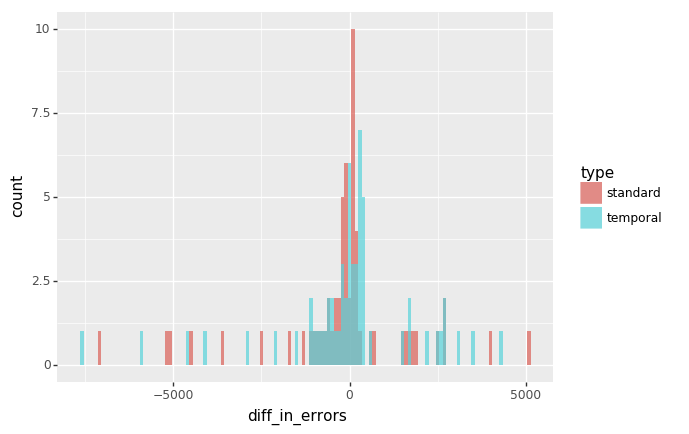

<ggplot: (-9223372036560800091)>

In [298]:
# Looking near 0 to remove some outliers
to_plot = temp_vs_std[temp_vs_std.abs_diff_in_errors < 8000]
(ggplot(to_plot, aes(x='diff_in_errors', fill='type')) +
    geom_histogram(binwidth=100, alpha=.7, position="identity")
)


From this plot we can see that both methods generally estimate the error lower than the true value. However, we can also see that standard CV technique appears to predict a lower error than the temporal, which is consistent with our reasons for preferring temporal cross validation explained above. Because standard cross validation trains many of its folds on data that occured after the year it was trying to predict, the predicted out-of-sample error is often too low.

It is also natural to ask about the absolute difference in the difference between the predicted and the actual errors for a given test year. That plot is below. Note that the temporal CV method seems to have slightly higher absolute absolute difference.

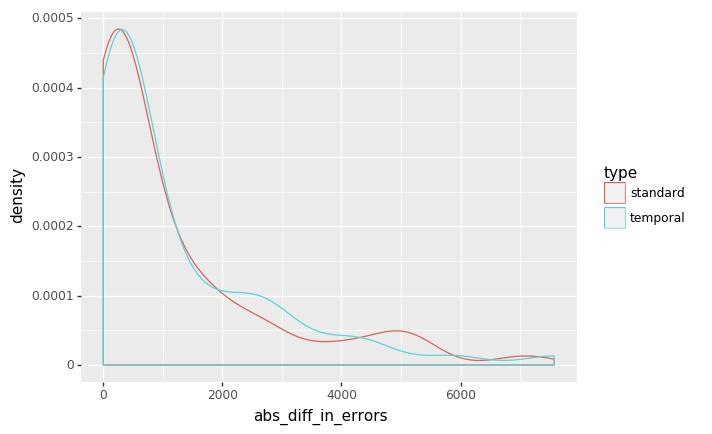

<ggplot: (295017792)>

In [300]:
ggplot(to_plot, aes(x="abs_diff_in_errors", colour='type')) + geom_density()

We can investigate how this difference in predicted vs actual error changes over the years tested. 

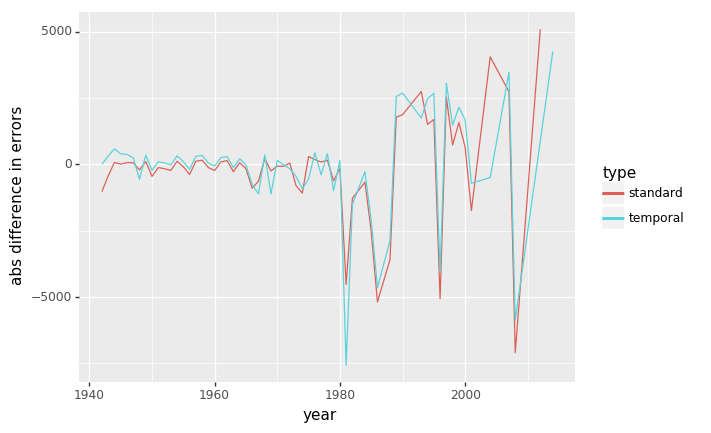

<ggplot: (-9223372036559470711)>

In [301]:
(ggplot(to_plot, aes(x='test_year', y='diff_in_errors', colour='type')) +
    geom_line() +
    xlab('year') +
    ylab('abs difference in errors')
)

Against expectations, the error does not shrink as the number of folds increases (later years). Instead, it seems to suddenly begin fluctuating wildly. 

## End of Jack's Work

In [362]:
results_long.value.groupby([results_long.model, results_long.cv_strategy, results_long.variable]).mean().round(0).sort_values()

model          cv_strategy  variable   
linear         temporal     train_error       299.0
ridge          temporal     train_error       310.0
elastic        temporal     train_error       431.0
random forest  temporal     train_error       870.0
linear         standard     train_error      1694.0
ridge          standard     train_error      1702.0
elastic        standard     train_error      2049.0
                            cv_error         3191.0
ridge          standard     cv_error         3424.0
linear         standard     cv_error         3505.0
ridge          temporal     cv_error         3518.0
elastic        temporal     cv_error         3842.0
linear         temporal     cv_error         3943.0
random forest  standard     train_error      4941.0
elastic        standard     test_error      22138.0
               temporal     test_error      22138.0
random forest  standard     cv_error        22967.0
ridge          temporal     test_error      23696.0
               standard 

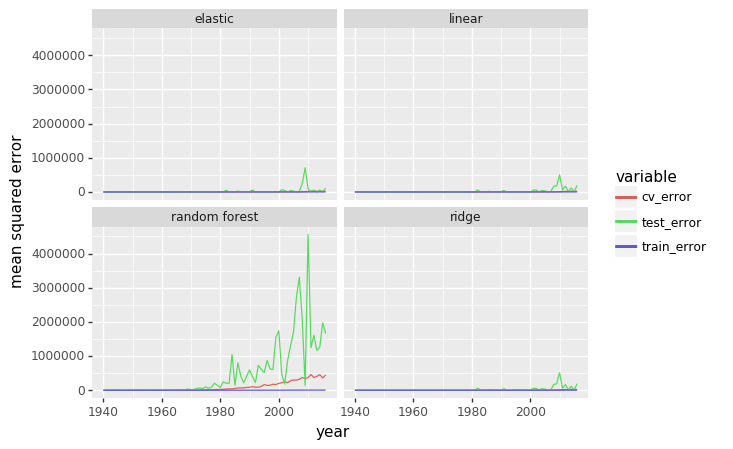

<ggplot: (291922145)>

In [347]:
(ggplot(temporal_results_long, aes(x='year', color='variable')) + 
    geom_line(aes(y='value', group='variable')) +
    xlab('year') +
    ylab('mean squared error') +
    facet_wrap('~model')
)

The OLS, ridge, and elasticnet regressions all give similar results, but we'd choose ridge regression given that it performed best (as measured by mean squared error, the metric we chose) out of sample.

### Temporal cross validation
In temporal cross validation, the training set contains rows that temporally precede the test set. In this setup,

* Train on rows through year t and test on t+1
* Train on rows through year t+1 and test on t+2
* ...
* Train on rows through year t+n-1 and test on t+n, where n is the number of rows in the training set

As mentioned, I set up the standard CV problem so each has the same exact validation sets. What differs is their training sets. Temporal CV only uses the rows that temporally precede the validation set, while standard CV will use all the rows not in the validation set. For example, if the validation set is 1990,

* Temporal CV will train on 1988 and 1989 only
* Standard CV will train on 1988, 1989, and 1991 through 2009

Note that the validation errors on each fold will converge toward the later years of the training set, as the training and validation data become more similar. Our leave-one-out CV strategy and temporal CV will give exactly the same results for the 2009 validation fold because the training (1988-2008) and validation (2009) data are the same. 

You'll almost always want to choose a validation and testing strategy that most closely mimics how your model will be used. If you don't, you'll choose a model that performs well for a different problem than the one you're trying to solve. In this example, where you want to predict GDP for 2018, you should choose temporal cross validation because you don't have data from after 2017. Training the model on future data and testing on the past is cheating because the future contains information about the past. As a result, standard cross validation will tend to give errors that are too small.  

We do not use the first row of data for validation because we don't have data that temporally precede it for training.

Unsurprisingly, we get the smallest errors on the training set and the largest errors on the test set.

How much of CV underestimation is due to lower variance?

Heavier penalties are more important for small samples

** should plot RMSE and GDP **

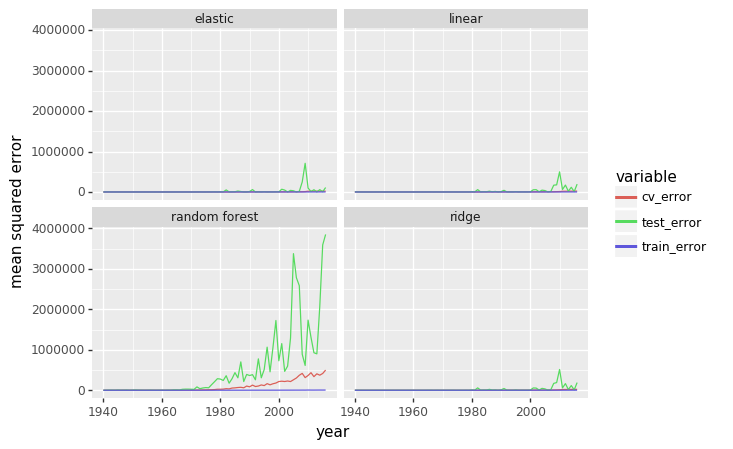

<ggplot: (291294363)>

In [251]:
(ggplot(#temporal_results_long[temporal_results_long.model != 'random forest']
    temporal_results_long, aes(x='year', color='variable')) + 
    geom_line(aes(y='value', group='variable')) +
    xlab('year') +
    ylab('mean squared error') +
    facet_wrap('~model')
)

#### If I were to choose the model with the lowest cross validation error, do I also get the lowest test error?

In [263]:
best_model_by_cv_error = temporal_results.sort_values(['year', 'cv_error']).groupby('year').iloc[:,1]  #.first().model
#best_model_by_test_error = temporal_results.sort_values(['year', 'test_error']).groupby('year').first().model
#best_models = pd.concat([best_model_by_cv_error, best_model_by_test_error], axis=1)
#best_models['match'] = best_models.iloc[:,0] == best_models.iloc[:,1]
#best_models.head()

AttributeError: Cannot access callable attribute 'iloc' of 'DataFrameGroupBy' objects, try using the 'apply' method

In [205]:
best_model_by_cv_error = temporal_results.sort_values(['year', 'cv_error']).groupby('year').first().model
best_model_by_test_error = temporal_results.sort_values(['year', 'test_error']).groupby('year').first().model
best_models = pd.concat([best_model_by_cv_error, best_model_by_test_error], axis=1)
best_models['match'] = best_models.iloc[:,0] == best_models.iloc[:,1]
best_models.head()

,model,model,match
year,,,
1940.0,random forest,elastic,False
1941.0,random forest,linear,False
1942.0,ridge,ridge,True
1943.0,ridge,ridge,True
1944.0,ridge,elastic,False


In [259]:
best_models['match'].groupby(best_models.match).count()

match
False    44
True     33
Name: match, dtype: int64

Standard practice chooses the model type with the lowest error rate on the validation set. Would that have been the best strategy for this problem? 

This example has 77 test sets. If we chose the model with the lowest cross validation error to predict e , and 33 times we would have  How likely are we to get at  Let's bootstrap for statistical significance (could also use binomial exact test, available in scipy)

In [256]:
a = np.random.choice(3, (77,10000))
b = np.random.choice(3, (77,10000))
c = np.equal(a, b)
np.mean(c.sum(axis=0) >= 33)

0.0516

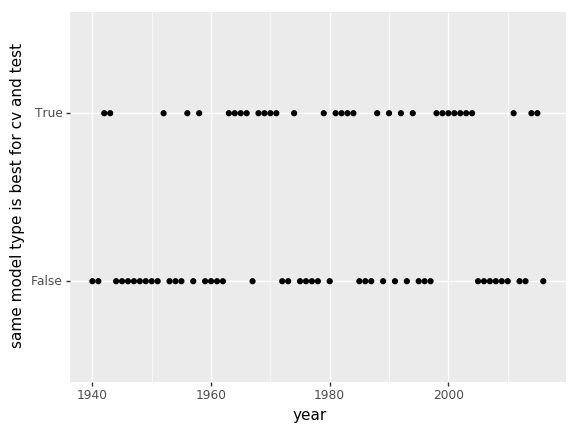

<ggplot: (290369295)>

In [226]:
(ggplot(best_models, aes(x=best_models.index, y=best_models.match)) +
    geom_point() +
    xlab('year') +
    ylab('same model type is best for cv and test')
)

In [190]:
x = temporal_results['cv_error'].groupby(temporal_results.year).min()
x.head()

year
1940.0    111.173827
1941.0    116.998936
1942.0    371.889946
1943.0    355.907023
1944.0    284.995931
Name: cv_error, dtype: float64

#### Plot MSE for standard and temporal strategies for each validation 
Standard CV almost always gives lower error rates because you've leaked information, and the differences are especially big when there is a shock or regime change (e.g. financial crisis)

In [260]:
standard_cv_results['cv_type'] = 'standard'
temporal_cv_results['cv_type'] = 'temporal'
cv_results = pd.concat([standard_cv_results, temporal_cv_results])

In [261]:
cv_results.head()

,linear_se,ridge_se,elastic_se,random_forest_se,cv_type
year,,,,,
1988,2090.078878,3223.115129,9547.677698,150009.0361,standard
1989,6603.851820,8485.857735,17560.710271,40666.7556,standard
1990,411.215297,735.700713,2820.090753,3075.8116,standard
1991,101.539354,151.839853,454.545031,340600.6321,standard
1992,17321.389288,15134.425808,8135.012647,118900.8324,standard


In [262]:
cv_results['year'] = cv_results.index

In [263]:
cv_results_long = pd.melt(cv_results, id_vars=['year', 'cv_type'])
cv_results_long.head()

,year,cv_type,variable,value
0,1988,standard,linear_se,2090.078878
1,1989,standard,linear_se,6603.851820
2,1990,standard,linear_se,411.215297
3,1991,standard,linear_se,101.539354
4,1992,standard,linear_se,17321.389288


In [279]:
cv_results_long['value'].groupby([cv_results_long['variable'], cv_results_long['cv_type']]).mean().round(0).sort_values()

variable          cv_type 
ridge_se          standard      44689.0
linear_se         standard      44727.0
elastic_se        standard      46154.0
                  temporal      56980.0
ridge_se          temporal      57742.0
linear_se         temporal      81451.0
random_forest_se  standard     212590.0
                  temporal    1027680.0
Name: value, dtype: float64

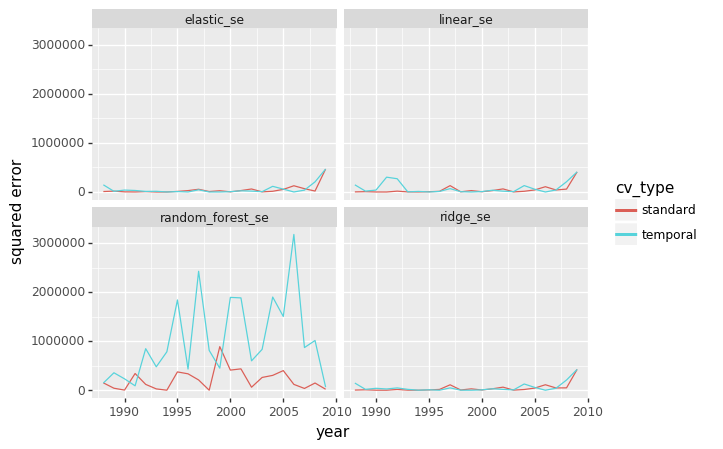

<ggplot: (-9223372036571730579)>

In [264]:
(ggplot(cv_results_long, aes(color='cv_type')) + 
    geom_line(aes(x='year', y='value', group='cv_type')) +
    xlab('year') +
    ylab('squared error') +
    facet_wrap('~variable')
)

There are some similarities with the standard CV results:

* Each CV approach gives the same accuracy on the last validation set (2009). That's because the train and validation sets are the same (train up to 2008, validate on 2009). 
* The least squares models offer similar performance. It's 

But there are plenty of differences:

* The most accurate model for standard CV (as measured by mean squared error on the validation data) is ridge regression. For temporal CV, it is ridge regression. They're related -- both use OLS with an L2 penalty -- but elasticnet also includes an L1 penalty.
* Standard CV gives lower MSE than temporal CV. That's what we'd expect, given that standard CV leaks information. 





These results suggest we should use *elastic net* -- a different (though related) type of model than what standard CV
suggested.

# Future
* Think about standard CV. The earlier the CV fold, the less like our problem. 
(The first fold is exactly the opposite because it is purely postdiction.) 
This is another possible way to show that validation setup should mimic our problem. 